In [34]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [2]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

In [4]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [23]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area
0,air_0f0cdeee6c9bf3d7,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,4
1,air_7cc17a324ae5c7dc,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,4
2,air_fee8dcf4d619598e,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,4
3,air_a17f0778617c76e2,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken,4
4,air_83db5aff8f50478e,6,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,13
...,...,...,...,...,...,...,...
824,air_9bf595ef095572fb,5,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,2
825,air_764f71040a413d4d,0,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,2
826,air_10bbe8acd943d8f6,0,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,2
827,air_7514d90009613cd6,9,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Hokkaidō,2


<AxesSubplot:>

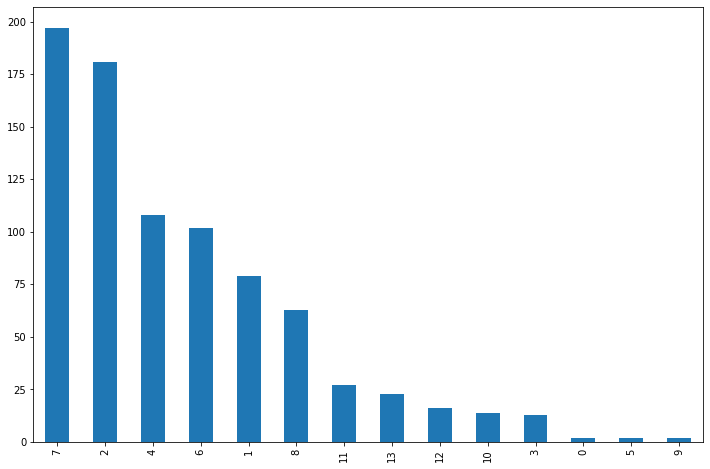

In [33]:
genre_counts = air_store['air_genre_name'].value_counts()
fig = plt.figure(figsize = (12, 8))
genre_counts.plot.bar(x = 'air_genre_name')

C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


<Figure size 864x576 with 0 Axes>

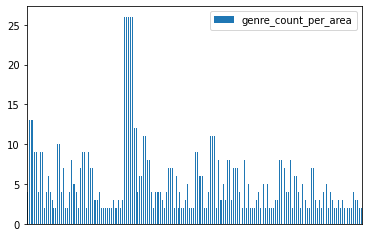

In [28]:
air_store['genre_count_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
fig = plt.figure(figsize = (12, 8))
air_store.plot.bar(x='air_area_name', y='genre_count_per_area', rot=0)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

In [ ]:
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [5]:
data

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,1
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0.000000,air_fff68b929994bfbd_2017-05-27,5,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,1
284123,air_fff68b929994bfbd,2017-05-28,0.000000,air_fff68b929994bfbd_2017-05-28,6,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,1
284124,air_fff68b929994bfbd,2017-05-29,0.000000,air_fff68b929994bfbd_2017-05-29,0,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,0
284125,air_fff68b929994bfbd,2017-05-30,0.000000,air_fff68b929994bfbd_2017-05-30,1,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,0


In [6]:
data['month'] = pd.to_datetime(data['visit_date']).dt.month

<AxesSubplot:xlabel='visit_date'>

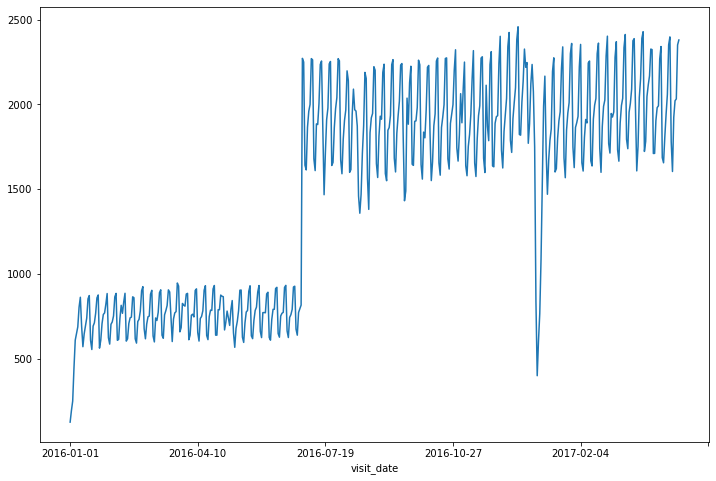

In [12]:
%matplotlib inline

visitors_per_date = train.groupby(['visit_date'])['visitors'].sum()

fig = plt.figure(figsize = (12, 8))
visitors_per_date.plot()

In [15]:
visitors_per_date

visit_date
2016-01-01     126.356968
2016-01-02     193.871163
2016-01-03     250.406298
2016-01-04     444.244727
2016-01-05     609.760021
                 ...     
2017-04-18    1924.141394
2017-04-19    2022.034013
2017-04-20    2032.607452
2017-04-21    2351.215787
2017-04-22    2380.459596
Name: visitors, Length: 478, dtype: float64

In [17]:
after_day_visitors = visitors_per_date.shift(periods=1).fillna(0)
visitor_variance = visitors_per_date - after_day_visitors

<AxesSubplot:xlabel='visit_date'>

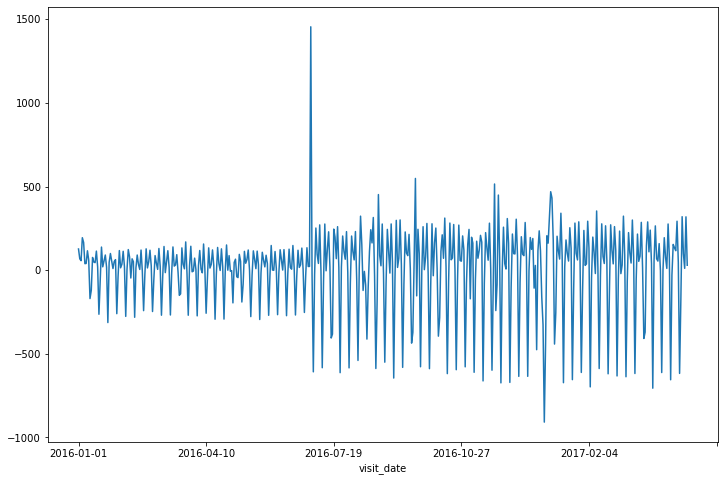

In [19]:
fig = plt.figure(figsize = (12, 8))
visitor_variance.plot()

In [21]:
sorted_visitor_variance = visitor_variance.sort_values(ascending=False)
sorted_visitor_variance

visit_date
2016-07-01    1455.300165
2016-09-21     548.229908
2016-11-22     514.984840
2017-01-05     468.943049
2016-08-23     451.806712
                 ...     
2017-01-15    -673.294047
2016-11-27    -674.397269
2017-02-05    -698.358775
2017-03-26    -706.233016
2016-12-31    -909.130883
Name: visitors, Length: 478, dtype: float64

In [22]:
data['expansion_after'] =((pd.to_datetime(data['visit_date']).dt.year >= 2016) | (pd.to_datetime(data['visit_date']).dt.month >= 7)).astype(int)
data

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2,month,expansion_after
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0,1,1
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0,1,1
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0,1,1
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,1,1,1
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,8,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0.000000,air_fff68b929994bfbd_2017-05-27,5,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,1,5,1
284123,air_fff68b929994bfbd,2017-05-28,0.000000,air_fff68b929994bfbd_2017-05-28,6,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,1,5,1
284124,air_fff68b929994bfbd,2017-05-29,0.000000,air_fff68b929994bfbd_2017-05-29,0,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,0,5,1
284125,air_fff68b929994bfbd,2017-05-30,0.000000,air_fff68b929994bfbd_2017-05-30,1,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,4,0,0,5,1


## 모델 구성 및 결과 예측

In [ ]:
train_size = len(air_visit)
train = data[:train_size]
test = data[train_size:]

In [ ]:
col = ['dow', 'air_genre_name', 'air_area_name0','genre_count_per_area', 'holiday_flg', 'holiday_flg2', 'month', 'expansion_after']
col

In [ ]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)

In [ ]:
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
model3.fit(train[col], np.log1p(train['visitors'].values))

In [ ]:
preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])

In [ ]:
test['visitors'] = 0.3*preds1+0.3*preds2+0.4*preds3
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)

In [ ]:
test

In [ ]:
sub = test[['id','visitors']].copy()
sub.to_csv('submission.csv', index=False)